<a href="https://colab.research.google.com/github/z27833009/Deep_Learning_4_NLP_Homework/blob/main/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/hw3

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/hw3


# **Task 1:  Sequence Tagging with RNNs**

In this task, you will implement LSTM and Bi-LSTM architectures with PyTorch to perform part-of-speech tagging (a sequence tagging task).

### **Data**
We use a subset of the data from the CoNLL-2003 shared task on Named Entity Recognition (provided in the zip). It is pre-partioned into a training, development and test set.

The dataset consists of pre-tokenized sentences where every token is annotated with a part-of-speech tag, a syntactic chunk tag and a named entity tag. In this home exercise, we only use the part-of-speech tag.

In [ ]:
import torch
import torch.nn as nn
import os
import re
import numpy as np
from collections import defaultdict
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

## **Task 1.1: Pretrained Embeddings (5p)**

Download the pretrained, uncased GloVe embeddings with 6B tokens [glove.6B.zip](https://nlp.stanford.edu/projects/glove/) from Stanford.

For performance reasons, we will only use the 50-dimensional embeddings **glove.6B.50d.txt**.

Implement a function to read the embedding and another function to read the dataset.

In [ ]:
def read_data(path):
    data = []
    labels = []

    with open(path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()
                token = parts[0].lower()
                label = parts[-1]
                # print(parts)
                # print(token,label)
                data.append(token)
                labels.append(label)


    return data,labels


def get_pretrained_embeddings(embedding_path):
    embeddings = defaultdict(list)

    with open(embedding_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                values = line.split()
                word = values[0]
                embedding = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
                embeddings[word] = embedding

    return embeddings





## **Task 1.2: LSTM and Bi-LSTM Model (10p)**

We will use PyTorch to build our LSTM. Complete the `__init__()` and the `forward()` function of the CustomLSTM class. The model will have the following components:
- A single [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer which takes the embeddings as input and has 100-dimensional hidden layer. The LSTM is **not** bidirectional.
- A dropout layer with probability 0.1
- A linear layer with input size of 100 (the hidden layer size of the LSTM layer) and output size of the number of labels
- A [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) activation function

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.LSTM(input_size, hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        output, _ = self.embedding(input)
        output = self.dropout(output)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

## **Task 1.3: Training Model (10p)**

Complete the function `train` to train your model. The model will train with batch size of 1 (each sentence split by "\n" is a sample) for 10 epochs. You will train the model with the train dataset and use dev dataset to check the model's performance after each epoch. Calculate the macro f1 score of the model on the dev set. Return the losses and f1 scores for plotting.

**Hint**: you can check out this [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) to get to know more about how to train model with pytorch. For the f1 score you can use `sklearn.metrics.f1_score`, remember to set the `average` parameter to "macro".


In [ ]:
def label_encode(labels):
    labels_list = {'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7,
                   'O': 8}
    # labels_encode = [labels_list[label] for label in labels]
    labels_encode = [labels_list.get(label, 9) for label in labels]
    return torch.tensor(labels_encode)

In [ ]:
# Change this to your path to the dataset
train = "/content/drive/MyDrive/Colab Notebooks/hw3/data/ner_eng_bio.dev"
test = "/content/drive/MyDrive/Colab Notebooks/hw3/data/ner_eng_bio.test"
dev = "/content/drive/MyDrive/Colab Notebooks/hw3/data/ner_eng_bio.train"

embeddings = get_pretrained_embeddings("/content/drive/MyDrive/Colab Notebooks/hw3/glove.6B.50d.txt")

train_data, train_label = read_data(train)
test_data, test_label = read_data(test)
dev_data, dev_label = read_data(dev)

# print(train_data[1:100])
# print(train_label[1:110])
def word2vec(data,embeddings):
  tokens=[]
  for token in data:
    if token in embeddings:
      tokens.append(embeddings[token])
    else:
      tokens.append(torch.tensor(np.random.normal(0, 1, 50), dtype=torch.float32))
  return tokens

# group token into sentences
def generate_sentences(token_list, ner_list):
    sentences = []
    ner_sentences = []
    current_sentence = []
    current_ner = []

    for token, ner in zip(token_list, ner_list):
        current_sentence.append(token)
        current_ner.append(ner)

        # If the current token is a sentence ending token (such as a period, question mark, exclamation point, etc.), add the current sentence to the list of sentences
        if token.endswith(('.', '?', '!')):
            sentences.append(current_sentence[:])
            ner_sentences.append(current_ner[:])
            current_sentence = []
            current_ner = []

    # If the last sentence does not have an ending flag, add it to the list of sentences
    if current_sentence:
        sentences.append(current_sentence)
        ner_sentences.append(current_ner)

    return sentences, ner_sentences

# transform sentences and labels into vectors and numerical labels
def preprocess_sentences(sentences, ner_sentences, embeddings):
    token_list = []
    ner_list = []

    for sentence, ner_sentence in zip(sentences, ner_sentences):
        tokens = word2vec(sentence, embeddings)
        ner_labels = label_encode(ner_sentence)

        token_list.append(tokens)
        ner_list.append(ner_labels)

    return token_list, ner_list

# Process train dataset
sentences, ner_sentences = generate_sentences(train_data, train_label)     # create sentences from tokens
emb_sentences, encod_ner =preprocess_sentences(sentences, ner_sentences,embeddings)   # convert sentence and labels into veectors and numbers
train_emb_sentences_tensor = [torch.stack(tokens) for tokens in emb_sentences]
train_encod_ner_tensor = [torch.tensor(labels) for labels in encod_ner]


# Process dev dataset
dev_sentences, dev_ner_sentences = generate_sentences(dev_data, dev_label)
dev_emb_sentences, dev_encod_ner = preprocess_sentences(dev_sentences, dev_ner_sentences, embeddings)
dev_emb_sentences_tensor = [torch.stack(tokens) for tokens in dev_emb_sentences]
dev_encod_ner_tensor = [torch.tensor(labels) for labels in dev_encod_ner]

# Process test dataset
test_sentences, test_ner_sentences = generate_sentences(test_data, test_label)
test_emb_sentences, test_encod_ner = preprocess_sentences(test_sentences, test_ner_sentences, embeddings)
test_emb_sentences_tensor = [torch.stack(tokens) for tokens in test_emb_sentences]
test_encod_ner_tensor = [torch.tensor(labels) for labels in test_encod_ner]



<ipython-input-87-3e5f9e3bc71c>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_encod_ner_tensor = [torch.tensor(labels) for labels in encod_ner]
<ipython-input-87-3e5f9e3bc71c>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dev_encod_ner_tensor = [torch.tensor(labels) for labels in dev_encod_ner]
<ipython-input-87-3e5f9e3bc71c>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_encod_ner_tensor = [torch.tensor(labels) for labels in test_encod_ner]


In [ ]:
print(f'Stentences length: {len(train_emb_sentences_tensor)}')
print(f'Tags length: {len(train_encod_ner_tensor)}\n')

print(f'Stentences[1] length: {len(train_emb_sentences_tensor[1])}')
print(f'Tags[1] length: {len(train_encod_ner_tensor[1])}\n')

print(sentences[1])
print((train_emb_sentences_tensor[1]))
print(train_emb_sentences_tensor[1].shape)

print((ner_sentences[1]))
print(train_encod_ner_tensor[1])
# print(train_encod_ner_tensor.shape) #error
# print(len(train_encod_ner_tensor))

Stentences length: 707
Tags length: 707

Stentences[1] length: 33
Tags[1] length: 33

['nadim', 'ladki', 'al-ain', ',', 'united', 'arab', 'emirates', '1996-12-06', 'japan', 'began', 'the', 'defence', 'of', 'their', 'asian', 'cup', 'title', 'with', 'a', 'lucky', '2-1', 'win', 'against', 'syria', 'in', 'a', 'group', 'c', 'championship', 'match', 'on', 'friday', '.']
tensor([[-3.6587e-01, -4.4553e-01,  1.1329e+00,  ..., -2.3450e-01,
          8.6040e-01,  1.0100e-01],
        [-4.5430e-01, -4.3524e-01, -1.3251e-01,  ...,  5.7889e-01,
          7.7915e-01,  6.9520e-01],
        [ 2.7189e-01, -7.7337e-02, -6.3594e-01,  ...,  6.3890e-02,
         -7.4534e-01, -2.1188e-01],
        ...,
        [ 3.0045e-01,  2.5006e-01, -1.6692e-01,  ..., -7.1310e-02,
          2.3052e-01, -5.1939e-01],
        [ 1.8662e-01,  6.7127e-02,  3.8229e-04,  ...,  7.5489e-01,
          2.8522e-01, -3.5622e-01],
        [ 1.5164e-01,  3.0177e-01, -1.6763e-01,  ..., -3.5652e-01,
          1.6413e-02,  1.0216e-01]])
t

In [ ]:
input_size = 50  # Dimension of input vectors
hidden_size = 100  # Dimension of LSTM hidden layer
output_size = 9  # Number of classes for NER labels
model = LSTM(input_size, hidden_size, output_size)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Set training parameters
num_epochs = 10
batch_size = 1

# Convert data to TensorDataset
train_emb_sentences_tensor = torch.cat(train_emb_sentences_tensor)  # before adding these two, error about different length
train_encod_ner_tensor = torch.cat(train_encod_ner_tensor)
# train_dataset = torch.utils.data.TensorDataset(train_emb_sentences_tensor, train_encod_ner_tensor)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# do the same
dev_emb_sentences_tensor = torch.cat(dev_emb_sentences_tensor)
dev_encod_ner_tensor = torch.cat(dev_encod_ner_tensor)
# dev_dataset = torch.utils.data.TensorDataset(dev_emb_sentences_tensor, dev_encod_ner_tensor)
# dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size)

def train(model, loss_fn, optimizer, train_data, train_label, dev_data, dev_label, epochs):
    logs_loss = []
    logs_f1_score = []

    train_dataset = torch.utils.data.TensorDataset(train_data, train_label)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0

        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.view(-1, output_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        logs_loss.append(avg_loss)

        model.eval()
        with torch.no_grad():
            dev_outputs = model(dev_data)
            dev_loss = loss_fn(dev_outputs.view(-1, output_size), dev_label.view(-1))
            dev_loss = dev_loss.item()

            dev_predictions = torch.argmax(dev_outputs, dim=1).view(-1)
            dev_labels = dev_label.view(-1)
            dev_f1_score = f1_score(dev_labels, dev_predictions, average='macro')
            logs_f1_score.append(dev_f1_score)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Dev Loss: {dev_loss:.4f}, Dev F1 Score: {dev_f1_score:.4f}")

    return logs_loss, logs_f1_score

logs_loss, logs_f1_score = train(model, loss_function, optimizer, train_emb_sentences_tensor, train_encod_ner_tensor, dev_emb_sentences_tensor, dev_encod_ner_tensor, num_epochs)

Epoch 1/10, Train Loss: 1.4840, Dev Loss: 1.5090, Dev F1 Score: 0.1704
Epoch 2/10, Train Loss: 1.4498, Dev Loss: 1.5009, Dev F1 Score: 0.2604
Epoch 3/10, Train Loss: 1.4409, Dev Loss: 1.5030, Dev F1 Score: 0.2654
Epoch 4/10, Train Loss: 1.4355, Dev Loss: 1.4996, Dev F1 Score: 0.2802
Epoch 5/10, Train Loss: 1.4317, Dev Loss: 1.5021, Dev F1 Score: 0.2645
Epoch 6/10, Train Loss: 1.4289, Dev Loss: 1.4944, Dev F1 Score: 0.2997
Epoch 7/10, Train Loss: 1.4272, Dev Loss: 1.5012, Dev F1 Score: 0.2735
Epoch 8/10, Train Loss: 1.4253, Dev Loss: 1.5003, Dev F1 Score: 0.2874
Epoch 9/10, Train Loss: 1.4238, Dev Loss: 1.5041, Dev F1 Score: 0.2856
Epoch 10/10, Train Loss: 1.4228, Dev Loss: 1.5010, Dev F1 Score: 0.2786


## **Task 1.4: Visualizing (5p)**

Check the performance of the model on the test set and plot the training loss using `matplotlib.pyplot.plot`.

<ipython-input-94-deec4dbdb5b8>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_encod_ner_tensor = [torch.tensor(labels) for labels in test_encod_ner]


Test Loss: 1.4486
Test F1 Score: 0.9088


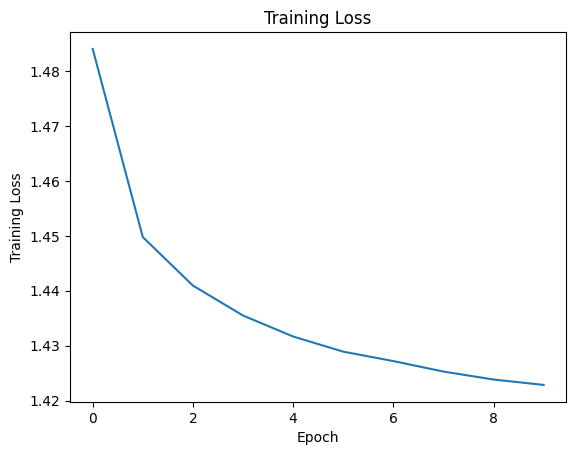

In [ ]:
test_sentences, test_ner_sentences = generate_sentences(test_data, test_label)
test_emb_sentences, test_encod_ner = preprocess_sentences(test_sentences, test_ner_sentences, embeddings)
test_emb_sentences_tensor = [torch.stack(tokens) for tokens in test_emb_sentences]
test_encod_ner_tensor = [torch.tensor(labels) for labels in test_encod_ner]
test_emb_sentences_tensor = torch.cat(test_emb_sentences_tensor)
test_encod_ner_tensor = torch.cat(test_encod_ner_tensor)
test_dataset = torch.utils.data.TensorDataset(test_emb_sentences_tensor, test_encod_ner_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Evaluate with test set
model.eval()
test_loss = 0
total_f1_score = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = loss_function(outputs.view(-1, output_size), targets.view(-1))
        test_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1).view(-1)
        targets = targets.view(-1)
        test_f1_score = f1_score(targets, predictions, average='macro')
        total_f1_score += test_f1_score  # Updated the variable name
test_loss /= len(test_loader)
total_f1_score /= len(test_loader)  # Updated the variable name
print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1 Score: {total_f1_score:.4f}")


# Plot with matplotlib
plt.plot(logs_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()
